In [101]:
import requests
from fake_useragent import UserAgent

from bs4 import BeautifulSoup
from lxml import etree
import json
import re

import warnings
warnings.filterwarnings("ignore")

from time import sleep
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from spellchecker import SpellChecker
from nltk.corpus import stopwords

# Получение синонимов с сайта

In [5]:
user_agent = UserAgent().chrome

In [28]:
res = requests.get('https://kartaslov.ru/синонимы-к-слову/для', headers={'User-Agent': user_agent})
bs = BeautifulSoup(res.content, 'html.parser')

In [29]:
a = bs.find_all('ul', attrs={'class': 'v2-syn-list'})
b = [i.find_all('a') for i in a]

res = []
for i in b:
    for j in i:
        res.append(j.text.replace('\xa0', ' '))
res

['в видах',
 'в интересах',
 'в угоду',
 'ради',
 'с целью',
 'к',
 'на',
 'в пользу кого',
 'в целях',
 'во избежание',
 'во исполнение',
 'для того, чтобы',
 'про',
 'чтобы']

In [ ]:
# l = bs.find_all('td', attrs={'class': 'nach'})
# [i.text for i in l if i.text!= '']

In [8]:
train = pd.read_csv('datasets/train.csv', index_col=0)
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45398 entries, 12405 to 13043
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   45398 non-null  object
 1   text    45398 non-null  object
 2   from    45398 non-null  object
 3   lemma   45398 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [41]:
test = pd.read_csv('datasets/test.csv', index_col=0)
test = test.dropna()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5960 entries, 14745 to 20671
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5960 non-null   object
 1   text    5960 non-null   object
 2   from    5960 non-null   object
 3   lemma   5960 non-null   object
dtypes: object(4)
memory usage: 232.8+ KB


In [9]:
words = set(' '.join(train.lemma).split( ))
len(words)

66015

In [10]:
words = list(words)

## Отберем только существующие слова

In [30]:
# https://royallib.com/book/ogegov_sergey/tolkoviy_slovar_russkogo_yazika.html - толковый словарь
text = ''
with open('synonyms/voc_all_words.txt', 'r', encoding='WINDOWS-1251') as f:
    text = f.read()
intro = '''Спасибо, что скачали книгу в бесплатной электронной библиотеке Royallib.ru: http://royallib.ru\n\nВсе книги автора: http://royallib.ru/author/ogegov_sergey.html\n\nЭта же книга в других форматах: http://royallib.ru/book/ogegov_sergey/tolkoviy_slovar_russkogo_yazika.html\n\nПриятного чтения!\n\n\n\n\nОжегов Сергей Иванович & Шведова Наталия Юльевна\n\nТолковый словарь русского языка'''
text = text[len(intro):].lower()
text[:3000]

'\n\n\n\na\n\nа, союз. 1. соединяет предложения или члены предложения, выражая противопоставление, сопоставление. он поехал, а я остался. пиши ручкой, а не карандашом. красив, а не умен. 2. присоединяет предложения или члены предложения со значением добавления чего-н. при последовательном изложении, со значением пояснения, возражения, усиления, перехода к другой мысли. на горе дом, а под горой ручей. было бы болото, а черти найдутся (посл.). что ты. сегодня делаешь? а завтра? он не виноват. - а кто же виноват, если не он? 3. употр. в начале вопросительных и восклицательных предложений, а также в начале речи для усиления выразительности, убедительности (часто в сочетании с местоимениями, наречиями, другими союзами). а как нам будет весело! а все-таки я не согласен. * а также (и), союз - выражает присоединение, усилительное или сопоставительное добавление. умелый водитель, а также и слесарь. снимается в кино, а также и на телевидении. а то - 1) союз, в противном случае, иначе. спеши, а т

In [31]:
symbols = re.findall("[а-я\s]", text) # Оставляем только буквы
text = ''.join(symbols)
text[:500]

'\n\n\n\n\n\nа союз  соединяет предложения или члены предложения выражая противопоставление сопоставление он поехал а я остался пиши ручкой а не карандашом красив а не умен  присоединяет предложения или члены предложения со значением добавления чегон при последовательном изложении со значением пояснения возражения усиления перехода к другой мысли на горе дом а под горой ручей было бы болото а черти найдутся посл что ты сегодня делаешь а завтра он не виноват  а кто же виноват если не он  употр в начале '

In [33]:
# https://dim-studio.ru/seo/xrumer/178-baza-russkih-slov-371-000-slov.html
text1 = ''
with open('synonyms/RUS.txt', 'r', encoding='WINDOWS-1251') as f:
    text1 = f.read()

' '.join(text1[:100].split())

'я не что в и ты это на с он вы да как мы мне а меня у нет так но то все его тебя за о она тебе если'

In [34]:
text2 = ''
with open('synonyms/russian.txt', 'r', encoding='WINDOWS-1251') as f:
    text2 = f.read()

print(text2[:1000].split())

['-де', '-ка', '-либо', '-нибудь', '-с', '-таки', '-то', 'а', 'а-конто', 'а-ля', 'а.л.', 'аарона', 'ааронов', 'аб', 'аба', 'абажур', 'абажура', 'абажурам', 'абажурами', 'абажурах', 'абажуре', 'абажурная', 'абажурного', 'абажурное', 'абажурной', 'абажурном', 'абажурному', 'абажурною', 'абажурную', 'абажурные', 'абажурный', 'абажурным', 'абажурными', 'абажурных', 'абажуров', 'абажуродержателе', 'абажуродержателей', 'абажуродержателем', 'абажуродержатели', 'абажуродержатель', 'абажуродержателю', 'абажуродержателя', 'абажуродержателям', 'абажуродержателями', 'абажуродержателях', 'абажуром', 'абажуру', 'абажурчик', 'абажурчика', 'абажурчикам', 'абажурчиками', 'абажурчиках', 'абажурчике', 'абажурчики', 'абажурчиков', 'абажурчиком', 'абажурчику', 'абажуры', 'абаз', 'абаза', 'абазам', 'абазами', 'абазах', 'абазе', 'абазией', 'абазиею', 'абазии', 'абазин', 'абазина', 'абазинам', 'абазинами', 'абазинах', 'абазине', 'абазинец', 'абазинка', 'абазинкам', 'абазинками', 'абазинках', 'абазинке', 'абаз

In [36]:
words = set(text.split()+ text1.split()+text2.split())
len(words) # уникальных слов во всех словарях

1696581

In [38]:
train.head()

label                                               text from  \
12405  positive                                 ахах, выполнено :)   vk   
981    positive  Не много, ни мало, но лишь одна из них заставл...   vk   
3263   positive                                       Я скучаю !!!   vk   
13036  positive        ОМГ какой милашка!)нереально не улыбнуться)   vk   
5683   positive               было охеренно, особенно дорога домой   vk   

                                                   lemma  
12405                                      ахи выполнить  
981    не много ни мало но лишь один из они заставлят...  
3263                                           я скучать  
13036         омг какой милашка нереальный не улыбнуться  
5683                быть охеренный особенно дорога домой

In [69]:
all_text = ' '.join(train.lemma)
text_words_train = set(all_text.split())
len(text_words_train) # уникальных слов в датасете

66015

In [70]:
all_text = ' '.join(test.lemma)
text_words_test = set(all_text.split())
len(text_words_test) # уникальных слов в датасете

20340

In [71]:
all_words = copy.copy(text_words_train)
all_words.update(text_words_test)
len(all_words) # уникальных слов в датасете

69978

In [72]:
len(all_words) - len(text_words_train) # кол-во уникальных слов в тестовом датасете

3963

In [75]:
unique_words_test = text_words_test - text_words_train
len(unique_words_test), unique_words_test

(3963,
 {'поквартально',
  'вслова',
  'сватовство',
  'лутшый',
  'авианосец',
  'тестики',
  'орнитолог',
  'живописиный',
  'стажировались',
  'завьра',
  'невыводимый',
  'сни',
  'павлин',
  'мгак',
  'дкрито',
  'многокорпусов',
  'ничнго',
  'выебываешься',
  'хуяцик',
  'вибратто',
  'пронесло',
  'букле',
  'саморазвитии',
  'действиттельно',
  'гон',
  'штурманский',
  'наоказывать',
  'облачались',
  'преодолевайте',
  'любберт',
  'безмерная',
  'сороссовский',
  'суицидный',
  'обезжириватель',
  'гимгин',
  'кобучению',
  'хичээгээд',
  'сползают',
  'зоофил',
  'фаберлик',
  'переменку',
  'огорчу',
  'делитантский',
  'кемпа',
  '_аллилуйя',
  'яростней',
  'пиздятина',
  'угробленные',
  'написанный',
  'краско',
  'вешалки',
  'занятия',
  'коловрата',
  'перегнуть',
  'плутократ',
  'обюдный',
  'сальфеджио',
  'еах',
  'переносица',
  'пропишить',
  'чгаки',
  'проосто',
  'общетехнический',
  'стерильность',
  'застявляя',
  'кирипичный',
  'зоро',
  'ретенок',
  '

In [77]:
len(all_words - words) # кол-во некорректных слов всего

24195

In [78]:
wrong_words = all_words - words
correct_words = all_words - wrong_words
len(correct_words)

45783

In [84]:
len(text_words_train - words), len(text_words_test - words)

(22139, 3109)

Text(0.5, 1.0, 'Тестовые данные')

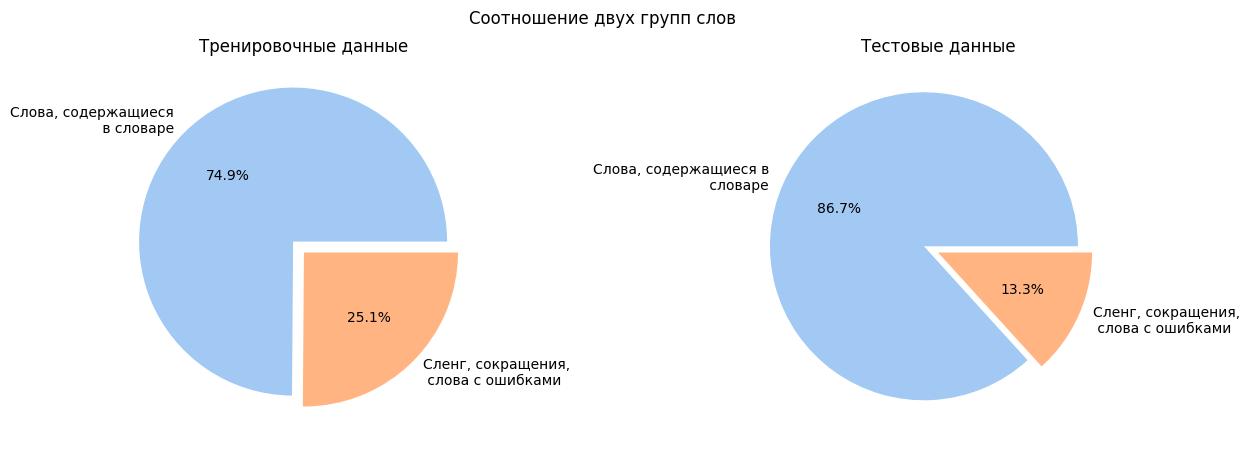

In [80]:
fig, ax = plt.subplots(1, 2)
fig.suptitle('Соотношение двух групп слов')
fig.set_size_inches(15, 5)


ax[0].pie([66015, 22139], labels = ['Слова, содержащиеся\n в словаре', 'Сленг, сокращения,\n слова с ошибками'], autopct='%.1f%%', 
          colors = sns.color_palette("pastel"), explode=[0.1, 0])
ax[0].set_title('Тренировочные данные')

ax[1].pie([20340, 3109], labels = ['Слова, содержащиеся в\n словаре', 'Сленг, сокращения,\n слова с ошибками'], autopct='%.1f%%', 
          colors = sns.color_palette("pastel"), explode=[0.1, 0])
ax[1].set_title('Тестовые данные')

## Исправляем слова с ошибками

In [87]:
spell = SpellChecker(language='ru')

misspelled = spell.unknown(wrong_words)
idx=0
for word in misspelled:
    if spell.correction(word):
        idx+=1
        if idx < 200:
            print(word, spell.correction(word))
print(idx)

избратиться избавиться
полюбом любом
няш наш
девчуля дедуля
ассес адрес
лоровец торговец
харфа пара
коффициент коэффициент
тыров таков
учиница ученица
надовать называть
мандал мадам
зайдуа зайду
зажимиться заниматься
устривать устраивать
доподбор подбор
вшня меня
прашивка правка
вощ вот
маоу маму
лайк майк
пронстранство пространство
мамомчек мамочке
орооса росса
развиватие развитие
ргаз раз
ощение общение
отчильный отдельный
увереный уверены
марофон марафон
редова едва
уверееность уверенность
уюрга утра
аалгах аллах
недумать подумать
боловуа голова
кафеда камера
выуз вы
фитболл футбол
стремлениюк стремление
преподоватеть преподаватель
возмошно возможно
коеференция конференция
гроул роуз
обечий обещай
подфак подай
помагалаа помогала
лайкай лайла
хвхаз хван
нуо но
жидать ждать
высер все
былета билета
смтрить смерть
ренний ранний
монтажик монтаж
лавил любил
обьем убьем
сполная полная
мордахи монахи
снюс нас
иполниться исполнится
замдекан замешан
пдп пап
сеечас сейчас
гараад гараж
непрекра

KeyboardInterrupt: 

## Получаем синонимы из словаря

In [12]:
text = ''
with open('synonyms/synonyms.html', 'r', encoding='WINDOWS-1251') as f:
    text = f.read()

text[:1000]

'<html xmlns:fb="http://www.gribuser.ru/xml/fictionbook/2.0" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:l="http://www.w3.org/1999/xlink">\n<head>\n<meta http-equiv="Content-Type" content="text/html; charset=windows-1251">\n<title>Словарь синонимов русского языка</title>\n<style type="text/css" media="screen">\n\t\tA { color : #0002CC }\n\t\tA:HOVER { color : #BF0000 }\n\t\tBODY {font-family : Verdana, Geneva, Arial, Helvetica, sans-serif; text-align : justify }\n\t\tH1{ font-size : 160%; font-style : normal; font-weight : bold; text-align : left; text-transform : capitalize;  border : 1px solid Black;  background-color : #E7E7E7; text-transform : capitalize;  margin-left : 0px;  padding-left : 0.5em;  }\n\t\tH2{ font-size : 130%; font-style : normal; font-weight : bold; text-align : left; text-transform : capitalize;  background-color : #EEEEEE;  border : 1px solid Gray; text-transform : capitalize;  padding-left : 1em; }\n\t\tH3{ font-size : 110%; font-style : normal; font-weigh

In [13]:
bs = BeautifulSoup(text, 'html.parser')
al = bs.find_all('blockquote', attrs={'class': 'epigraph'})
len(al), str(al[0]).split('</i><br/>\xa0\xa0\xa0')

(23,
 ['<blockquote class="epigraph"><i>\xa0\xa0\xa0<i><b>Имена существительные </b>',
  'БЕСКОРЫ́СТИЕ, альтруи́зм.<br/>\xa0\xa0\xa0Забота о благе других, готовность жертвовать для других своими личными интересами.<br/>\xa0\xa0\xa0БЛАГОТВОРИ́ТЕЛЬНОСТЬ, филантро́пия.<br/>\xa0\xa0\xa0Способность заботиться о ком-, чём-либо, оказывая материальную и другую помощь.<br/>\xa0\xa0\xa0ГОСТЕПРИИ́МСТВО, гостеприи́мность, раду́шие, хлебосо́льство.<br/>\xa0\xa0\xa0Сердечное, ласковое отношение к людям, приветливость, открытость, готовность и умение радушно и щедро принять гостей, угостить их.<br/>\xa0\xa0\xa0ДОБРОТА́, добросерде́чие, добросерде́чность, душе́вность, мягкосерде́чие, мягкосерде́чность, мя́гкость, серде́чность, <i>книжн. </i>бла́гость.<br/>\xa0\xa0\xa0Душевное расположение к людям, благожелательность, отзывчивость, стремление делать добро другим.<br/>\xa0\xa0\xa0ДОБРОДУ́ШИЕ, беззло́бие, благоду́шие, незло́би́вость.<br/>\xa0\xa0\xa0Качество, свойство человека, заключающееся в мягкосерде

In [16]:
t = str(al[0]).split('<br/>\xa0\xa0\xa0')
len(t)

48

In [17]:
cleared = [re.sub(r'<i>[\d\s\S]+</i>', '',  i) for i in t] 
cleared

['<blockquote class="epigraph">',
 'БЕСКОРЫ́СТИЕ, альтруи́зм.',
 'Забота о благе других, готовность жертвовать для других своими личными интересами.',
 'БЛАГОТВОРИ́ТЕЛЬНОСТЬ, филантро́пия.',
 'Способность заботиться о ком-, чём-либо, оказывая материальную и другую помощь.',
 'ГОСТЕПРИИ́МСТВО, гостеприи́мность, раду́шие, хлебосо́льство.',
 'Сердечное, ласковое отношение к людям, приветливость, открытость, готовность и умение радушно и щедро принять гостей, угостить их.',
 'ДОБРОТА́, добросерде́чие, добросерде́чность, душе́вность, мягкосерде́чие, мягкосерде́чность, мя́гкость, серде́чность, бла́гость.',
 'Душевное расположение к людям, благожелательность, отзывчивость, стремление делать добро другим.',
 'ДОБРОДУ́ШИЕ, беззло́бие, благоду́шие, незло́би́вость.',
 'Качество, свойство человека, заключающееся в мягкосердечии, доброте, отсутствии злобы.',
 'ДОБРОЖЕЛА́ТЕЛЬ, благожела́тель, доброхо́т.',
 'Тот, кто желает добра другим, исполнен расположения, участия.',
 'ДОБРОЖЕЛА́ТЕЛЬНОСТЬ, благож

In [18]:
re.search('[А-ЯЁё]+', ', благожела́тельн')

In [19]:
tmp = []
for i in cleared:
    if re.search('[А-ЯЁё]{2,}', i):
        tmp.append(i)
tmp

['БЕСКОРЫ́СТИЕ, альтруи́зм.',
 'БЛАГОТВОРИ́ТЕЛЬНОСТЬ, филантро́пия.',
 'ГОСТЕПРИИ́МСТВО, гостеприи́мность, раду́шие, хлебосо́льство.',
 'ДОБРОТА́, добросерде́чие, добросерде́чность, душе́вность, мягкосерде́чие, мягкосерде́чность, мя́гкость, серде́чность, бла́гость.',
 'ДОБРОДУ́ШИЕ, беззло́бие, благоду́шие, незло́би́вость.',
 'ДОБРОЖЕЛА́ТЕЛЬ, благожела́тель, доброхо́т.',
 'ДОБРОЖЕЛА́ТЕЛЬНОСТЬ, благожела́тельность, благоскло́нность, доброжела́тельство, дружелю́бие, доброхо́тство.',
 'ОТЗЫ́ВЧИВОСТЬ, душе́вность, серде́чность, уча́стливость, чу́ткость.',
 'СНИСХОЖДЕ́НИЕ, ми́лость, одолже́ние.',
 'СНИСХОДИ́ТЕЛЬНОСТЬ, либерали́зм, либера́льность, мя́гкость, невзыска́тельность, нетре́бовательность, снисхожде́ние, терпи́мость, толера́нтность.',
 'БЕСКОРЫ́СТНЫЙ, платони́ческий, альтруисти́ческий, альтруистичный.',
 'БЛАГОСКЛО́ННЫЙ, ми́лостивый.',
 'БЛАГОТВОРИ́ТЕЛЬНЫЙ, филантропи́ческий.',
 'ГОСТЕПРИИ́МНЫЙ, раду́шный, хлебосо́льный.',
 'ДОБРОДУ́ШНЫЙ, беззло́бный, мягкосерде́чный, незло́бивый, не

In [20]:
result = []

for i in tmp:
    x = i.replace('/', ',').replace('.', '')
    x = x.split(',')
    result.append([j.strip().lower() for j in x])

result

[['бескоры́стие', 'альтруи́зм'],
 ['благотвори́тельность', 'филантро́пия'],
 ['гостеприи́мство', 'гостеприи́мность', 'раду́шие', 'хлебосо́льство'],
 ['доброта́',
  'добросерде́чие',
  'добросерде́чность',
  'душе́вность',
  'мягкосерде́чие',
  'мягкосерде́чность',
  'мя́гкость',
  'серде́чность',
  'бла́гость'],
 ['доброду́шие', 'беззло́бие', 'благоду́шие', 'незло́би́вость'],
 ['доброжела́тель', 'благожела́тель', 'доброхо́т'],
 ['доброжела́тельность',
  'благожела́тельность',
  'благоскло́нность',
  'доброжела́тельство',
  'дружелю́бие',
  'доброхо́тство'],
 ['отзы́вчивость',
  'душе́вность',
  'серде́чность',
  'уча́стливость',
  'чу́ткость'],
 ['снисхожде́ние', 'ми́лость', 'одолже́ние'],
 ['снисходи́тельность',
  'либерали́зм',
  'либера́льность',
  'мя́гкость',
  'невзыска́тельность',
  'нетре́бовательность',
  'снисхожде́ние',
  'терпи́мость',
  'толера́нтность'],
 ['бескоры́стный', 'платони́ческий', 'альтруисти́ческий', 'альтруистичный'],
 ['благоскло́нный', 'ми́лостивый'],
 ['бла

In [21]:
# Буквы с акутом


x = 'А́ а́ Б́ б́ В́ в́ Ѓ ѓ Д́ д́ Е́ е́ Ё́ ё́ Ж́ ж́ З́ з́ И́ и́ Й́ й́ Ќ ќ Л́ л́ М́ м́ Н́ н́ О́ о́ П́ п́ Р́ р́ С́ с́ Т́ т́ У́ у́ Ф́ ф́ Х́ х́ Ц́ ц́ Ч́ ч́ Ш́ ш́ Щ́ щ́ Ъ́ ъ́ Ы́ ы́ Ь́ ь́ Э́ э́ Ю́ ю́ Я́ я́'
x = x.lower().split(' ')[::2]
y= ['а', 'б','в','г','д','е','ё','ж','з','и','й','к','л','м','н','о','п', 'р',  'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь',
    'э', 'ю', 'я']
print(len(x), x)
print(len(y), y)

33 ['а́', 'б́', 'в́', 'ѓ', 'д́', 'е́', 'ё́', 'ж́', 'з́', 'и́', 'й́', 'ќ', 'л́', 'м́', 'н́', 'о́', 'п́', 'р́', 'с́', 'т́', 'у́', 'ф́', 'х́', 'ц́', 'ч́', 'ш́', 'щ́', 'ъ́', 'ы́', 'ь́', 'э́', 'ю́', 'я́']
33 ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


In [22]:
# Заменяем буквы с акутом
i = 0
while i < len(result):
    j = 0
    while j < len(result[i]):
        for key, char in enumerate(x):
            if char in result[i][j]:
                result[i][j] = result[i][j].replace(char, y[key])
        j+=1
    i+=1

In [23]:
text = ''
with open('synonyms/synonyms.html', 'r', encoding='WINDOWS-1251') as f:
    text = f.read()

bs = BeautifulSoup(text, 'html.parser')
epigraphs = str(bs.body).split('...')[1:] #.text.split('...')[1:]
all_words = []
for i in epigraphs:
    all_words.extend(i.split('\xa0\xa0\xa0'))

def del_i(text):
    cleared = [re.sub(r'<i>[^<>]+</i>', ' ',  i) for i in text] 
    cleared = [i.replace('<br/>', '') for i in cleared]
    return cleared

def get_only_words(cleared):
    tmp = []
    for i in cleared:
        if re.search('[А-ЯЁё]{2,}', i):
            tmp.append(i)
    return tmp

def split_words(text):
    result = []
    for i in text:
        x = i.replace('/', ',').replace('.', '')
        x = x.split(',')
        result.append([j.strip().lower() for j in x if len(j.strip().lower()) != 0])

    return result

all_words = get_only_words(all_words)
# print(all_words)
all_words = del_i(all_words)
all_words = split_words(all_words)
print(len(all_words))

i = 0
while i < len(all_words):
    j = 0
    while j < len(all_words[i]):
        for key, char in enumerate(x):
            if char in all_words[i][j]:
                # print(key, len(x))
                all_words[i][j] = all_words[i][j].replace(char, y[key])
        j+=1
    i+=1

5071


In [24]:
with open('synonyms/synonyms_vocab.json', 'w') as f:
    f.write(json.dumps(all_words))

In [105]:
with open('synonyms/synonyms_vocab.json', 'r') as f:
    all_words = json.loads(f.read())
    print(all_words[:100])

[['бескорыстие', 'альтруизм'], ['благотворительность', 'филантропия'], ['гостеприимство', 'гостеприимность', 'радушие', 'хлебосольство'], ['доброта', 'добросердечие', 'добросердечность', 'душевность', 'мягкосердечие', 'мягкосердечность', 'мягкость', 'сердечность', 'благость'], ['добродушие', 'беззлобие', 'благодушие', 'незлобивость'], ['доброжелатель', 'благожелатель', 'доброхот'], ['доброжелательность', 'благожелательность', 'благосклонность', 'доброжелательство', 'дружелюбие', 'доброхотство'], ['отзывчивость', 'душевность', 'сердечность', 'участливость', 'чуткость'], ['снисхождение', 'милость', 'одолжение'], ['снисходительность', 'либерализм', 'либеральность', 'мягкость', 'невзыскательность', 'нетребовательность', 'снисхождение', 'терпимость', 'толерантность'], ['бескорыстный', 'платонический', 'альтруистический', 'альтруистичный'], ['благосклонный', 'благорасположенный', 'милостивый'], ['благотворительный', 'филантропический'], ['гостеприимный', 'радушный', 'хлебосольный'], ['доброд

In [26]:
def find_syn(word):
    syn = []
    for i in all_words:
        if word in i:
            syn.extend(i)
    return syn

find_syn('болото')

['болото',
 'топь',
 'трясина',
 'блато',
 'болотина',
 'зыбун',
 'захолустье',
 'глубинка',
 'глушь',
 'дичь',
 'закоулок',
 'трущоба',
 'болото',
 'глухомань',
 'дыра',
 'пошехонье',
 'тмутаракань и',
 'тьмутаракань']

In [27]:
tmp ={'выполнить': 0, 'не': 1, 'ни': 2, 'мало': 3, 'лишь': 4, 'заставлять': 5, 'думать': 6, 'засыпать': 7, 'брать': 8, 'рука': 9, 'знать': 10, 'счастие': 11, 'хотеть': 12, 'проснуться': 13, 'утро': 14, 'давно': 15, 'стать': 16, 'интересно': 17, 'жутко': 18, 'сын': 19, 'дочка': 20, 'гадать': 21, 'просто': 22, 'казаться': 23, 'звать': 24, 'мама': 25, 'скучать': 26, 'милашка': 27, 'нереальный': 28, 'улыбнуться': 29, 'особенно': 30, 'дорога': 31, 'домой': 32, 'лучше': 33, 'очень': 34, 'классный': 35, 'ава': 36, 'сказать': 37, 'ха_ха': 38, 'выбрать': 39, 'мужчина': 40, 'главное': 41, 'деньга': 42, 'собирать': 43, 'точка': 44, 'папа': 45, 'первый': 46, 'герой': 47, 'любовь': 48, 'дочь': 49, 'хах': 50, 'писать': 51, 'сегодня': 52, 'посмотреть': 53, 'понравиться': 54, 'пятница': 55, 'каток': 56, 'конек': 57, 'склон': 58, 'победитель': 59, 'оо': 60, 'мило': 61, 'прекрасный': 62, 'работа': 63, 'дом': 64, 'продолжить': 65, 'территория': 66, 'работать': 67, 'дома': 68, 'коворкинг': 69, 'выходной': 70, 'мелкий': 71, 'спокойнее': 72, 'мандаринка': 73, 'самый': 74, 'крутой': 75, 'оптический': 76, 'иллюзия': 77, 'видеть': 78, 'лента': 79, 'наткнуться': 80, 'забава': 81, 'открыть': 82, 'близкий': 83, 'книга': 84, 'страница': 85, 'прочесть': 86, 'верхний': 87, 'предложение': 88, 'охарактеризовать': 89, 'любовный': 90, 'жизнь': 91, 'поддаться': 92, 'честно': 93, 'говорить': 94, 'поразить': 95, 'результат': 96, 'ибо': 97, 'всякий': 98, 'случаться': 99, 'знак': 100, 'накопление': 101, 'сила': 102, 'мочь': 103, 'сверху': 104, 'строка': 105, 'глаз': 106, 'сиять': 107, 'яркий': 108, 'звезда': 109, 'заговорить': 110, 'нежно': 111}

for i in tmp.keys():
    print(i, find_syn(i))

выполнить ['учить', 'выучить', 'выполнять', 'выполнить', 'выучивать', 'выучить', 'готовить', 'приготовить', 'делать', 'сделать', 'заучивать', 'заучить', 'приготовлять', 'приготовить', 'разучивать', 'разучить', 'выдалбливать', 'выдолбить', 'вызубривать', 'вызубрить', 'вытверживать', 'вытвердить', 'долбить', 'выдолбить', 'задалбливать', 'задолбить', 'зазубривать', 'зазубрить', 'затверживать', 'затвердить', 'зубрить', 'вызубрить и зазубрить', 'твердить', 'вытвердить', 'осуществлять', 'осуществить', 'выполнять', 'выполнить', 'исполнять', 'исполнить', 'и  реализовать', 'реализовывать', 'реализовать', 'осуществлять', 'осуществить', 'выполнять', 'выполнить', 'исполнять', 'исполнить', 'и  реализовать', 'и  материализовать']
не []
ни []
мало ['мало', 'немного', 'несколько', 'слегка', 'чуть', 'чуть-чуть', 'всего ничего', 'капельку', 'каплю', 'крохотку', 'крошечку', 'крошку', 'немножко', 'чуточку', 'недостаточно', 'мало']
лишь ['исключительно', 'единственно', 'именно', 'лишь', 'толькоуказывает', 

In [106]:
syn_dict = {}

for i in all_words:
    tmp = set(i)
    del_ = stopwords.words("russian")

    for j in del_:
        if j in tmp:
            tmp.remove(j)
    
    syn_dict[i[0]] = tmp

In [107]:
syn_dict

{'бескорыстие': {'альтруизм', 'бескорыстие'},
 'благотворительность': {'благотворительность', 'меценатство', 'филантропия'},
 'гостеприимство': {'гостеприимность',
  'гостеприимство',
  'радушие',
  'хлебосольство'},
 'доброта': {'благость',
  'добросердечие',
  'добросердечность',
  'доброта',
  'душевность',
  'мягкосердечие',
  'мягкосердечность',
  'мягкость',
  'сердечность'},
 'добродушие': {'беззлобие', 'благодушие', 'добродушие', 'незлобивость'},
 'доброжелатель': {'благожелатель', 'доброжелатель', 'доброхот'},
 'доброжелательность': {'благожелательность',
  'благосклонность',
  'доброжелательность',
  'доброжелательство',
  'доброхотство',
  'дружелюбие'},
 'отзывчивость': {'душевность',
  'отзывчивость',
  'сердечность',
  'участливость',
  'чуткость'},
 'снисхождение': {'милость', 'одолжение', 'снисхождение'},
 'снисходительность': {'либерализм',
  'либеральность',
  'мягкость',
  'невзыскательность',
  'недостаткам и тп других',
  'нетребовательность',
  'ошибкам',
  'слабо

In [108]:
def get_syn(word):
    if word in syn_dict:
        return word

    for key, value in syn_dict.items():
        if word in value:
            print(word, '->', key, value)
            return key
    else:
        return word

get_syn('топь')

топь -> болото {'топь', 'блато', 'болотина', 'трясина', 'зыбун', 'болото'}


'болото'

# Получаем существуюшие слова из словарей

In [47]:
text = ''
with open('synonyms/voc_all_words.txt', 'r', encoding='WINDOWS-1251') as f:
    text = f.read()
intro = '''Спасибо, что скачали книгу в бесплатной электронной библиотеке Royallib.ru: http://royallib.ru\n\nВсе книги автора: http://royallib.ru/author/ogegov_sergey.html\n\nЭта же книга в других форматах: http://royallib.ru/book/ogegov_sergey/tolkoviy_slovar_russkogo_yazika.html\n\nПриятного чтения!\n\n\n\n\nОжегов Сергей Иванович & Шведова Наталия Юльевна\n\nТолковый словарь русского языка'''
text = text[len(intro):].lower()
text[:3000]
symbols = re.findall("[а-я\s]", text) # Оставляем только буквы
text = ''.join(symbols)
text[:500]

'\n\n\n\n\n\nа союз  соединяет предложения или члены предложения выражая противопоставление сопоставление он поехал а я остался пиши ручкой а не карандашом красив а не умен  присоединяет предложения или члены предложения со значением добавления чегон при последовательном изложении со значением пояснения возражения усиления перехода к другой мысли на горе дом а под горой ручей было бы болото а черти найдутся посл что ты сегодня делаешь а завтра он не виноват  а кто же виноват если не он  употр в начале '

In [48]:
text1 = ''
with open('synonyms/RUS.txt', 'r', encoding='WINDOWS-1251') as f:
    text1 = f.read()

print(text1[:100].split())

['я', 'не', 'что', 'в', 'и', 'ты', 'это', 'на', 'с', 'он', 'вы', 'да', 'как', 'мы', 'мне', 'а', 'меня', 'у', 'нет', 'так', 'но', 'то', 'все', 'его', 'тебя', 'за', 'о', 'она', 'тебе', 'если']


In [49]:
text2 = ''
with open('synonyms/russian.txt', 'r', encoding='WINDOWS-1251') as f:
    text2 = f.read()

print(text2[:1000].split())

['-де', '-ка', '-либо', '-нибудь', '-с', '-таки', '-то', 'а', 'а-конто', 'а-ля', 'а.л.', 'аарона', 'ааронов', 'аб', 'аба', 'абажур', 'абажура', 'абажурам', 'абажурами', 'абажурах', 'абажуре', 'абажурная', 'абажурного', 'абажурное', 'абажурной', 'абажурном', 'абажурному', 'абажурною', 'абажурную', 'абажурные', 'абажурный', 'абажурным', 'абажурными', 'абажурных', 'абажуров', 'абажуродержателе', 'абажуродержателей', 'абажуродержателем', 'абажуродержатели', 'абажуродержатель', 'абажуродержателю', 'абажуродержателя', 'абажуродержателям', 'абажуродержателями', 'абажуродержателях', 'абажуром', 'абажуру', 'абажурчик', 'абажурчика', 'абажурчикам', 'абажурчиками', 'абажурчиках', 'абажурчике', 'абажурчики', 'абажурчиков', 'абажурчиком', 'абажурчику', 'абажуры', 'абаз', 'абаза', 'абазам', 'абазами', 'абазах', 'абазе', 'абазией', 'абазиею', 'абазии', 'абазин', 'абазина', 'абазинам', 'абазинами', 'абазинах', 'абазине', 'абазинец', 'абазинка', 'абазинкам', 'абазинками', 'абазинках', 'абазинке', 'абаз

In [55]:
voc_words = set(text.split()+ text1.split()+text2.split())
len(voc_words)

1696581

In [63]:
wrong_words = np.diff([np.array(voc_words), np.array(set(words))])
print(len(wrong_words[0]))

22139


In [71]:
correct_words = np.diff([wrong_words[0], np.array(set(words))])
print(len(correct_words[0]))

43876


In [72]:
len(set(words))

66015

In [76]:
correct_words.shape, list(correct_words[0])

((1,),
 ['безворсовый',
  'понимаете',
  'трудолюбие',
  'загоризонтный',
  'хельсинки',
  'тыквочка',
  'начинание',
  'подсушить',
  'дая',
  'проезжий',
  'учащаться',
  'почистить',
  'бессонные',
  'товароведение',
  'пороговый',
  'затвердеть',
  'закипеть',
  'веточка',
  'правоотношение',
  'песчинка',
  'подкатывать',
  'интермедиат',
  'несмотря',
  'застенчивых',
  'тс',
  'х',
  'продолжительность',
  'думалось',
  'вынос',
  'прогул',
  'их',
  'покрыть',
  'субботник',
  'набить',
  'шахматный',
  'запихать',
  'называетесь',
  'учудил',
  'парижанин',
  'служанка',
  'гигантский',
  'нажиться',
  'формирование',
  'танцевальный',
  'ика',
  'необорудованный',
  'удерживаться',
  'стареешь',
  'экономист',
  'вазочка',
  'разносторонний',
  'очаровывать',
  'уставать',
  'ведомство',
  'устояться',
  'аккредитационный',
  'вывешивается',
  'пореже',
  'радиатор',
  'достигнете',
  'озвучивание',
  'тренироваться',
  'детсадовский',
  'расстояние',
  'отмахнулись',
  'ножи

# Получение синонимов с сайта

### Сайт №1

In [88]:
res = requests.get('https://sinonim.org/s/предполагать#f', headers={'User-Agent': user_agent})
bs = BeautifulSoup(res.content, 'html.parser')

In [90]:
# bs.prettify()

In [92]:
al = bs.find_all('tr')
# one = al.find_all('td')
# print(len(one), one[1].text, one[5].text, one[3].text, len(al)) # dir(al[1]),

# print(re.sub('\([\d]+\)','',  one[1].text))

In [93]:
def get_all_words(bs, id_):
    table = bs.find_all('tr')
    idx = 0
    print(len(table))
    result = pd.DataFrame(columns=['group_id', 'word', 'lemma', 'score', 'frequency'])


    
    for row in table:
        one = row.find_all('td')
        if one and len(one)>=6:
            result.loc[idx] = [id_, re.sub('\([\d]+\)', '',  one[1].text).strip(), one[-4].text.strip(), one[-3].text.strip(), one[-1].text.strip()]
            idx+=1
    return result

get_all_words(bs, 10).tail(20)

79


group_id                     word                 lemma score frequency
57        10               иметь план            иметь план     0    0.0022
58        10               загадывать                           0         -
59        10             догадываться                           0         -
60        10            предпринимать                           0         -
61        10         выразить надежду                           0         -
62        10        считаем возможным                           0         -
63        10            имплицировать                           0         -
64        10            презюмировать                           0         -
65        10          вознамериваться       вознамериваться     0         -
66        10     иметь своим условием  иметь своим условием     0    0.0004
67        10                   мекать                мекать     0         -
68        10            заподозривать         заподозривать     0         -
69        10             гипотетичный          гипотетичный     0         -
70        10            заподазривать         заподазривать     0         -
71        10            подразумевает                           0         -
72        10  подразумевает под собой                           0         -
73        10            презумптивный         презумптивный     0         -
74        10               подумывать                           0         -
75        10          предусматривать       предусматривать    -1      30.5
76        10                   метить                метить    -1       4.6

In [95]:
main_df = pd.DataFrame(columns=['word'])
word_dict = {}
all_words = list(correct_words)
errors = 0
i=0
while i < len(all_words):
    word = all_words[i]
    if word in word_dict:
        print(f'remove word {word}')
        all_words.remove(word)
    else:
        print(f'Try to get: https://sinonim.org/s/{word}#f')
        res = requests.get(f'https://sinonim.org/s/{word}', headers={'User-Agent': user_agent})
        bs = BeautifulSoup(res.content, 'html.parser')

        # Предупреждение от сайта:
        #  Если мы обнаруживаем парсинг, то стараемся искажать контент так, 
        # чтобы его было бесполезно использовать (заменяем некоторые буквы, слова) 
        
        try:
            df = get_all_words(bs, i)
            main_df = pd.concat([main_df, df], ignore_index=True)
            word_dict[word] = i
            i+=1
            sleep(5)
        except:
            print('Error')
            errors+=1
    
        if i % 1000 == 0 or i >= len(all_words):
            print(i, 'save synonyms')
            main_df.to_csv(f'synonyms/synonyms_{i//1000}.csv')
            with open(f'synonyms/dict_synonyms_{i//1000}.json', 'w') as f:
                f.write(json.dumps(word_dict))

Try to get: https://sinonim.org/s/содержательный#f
36
Try to get: https://sinonim.org/s/предусмотрительно#f
10
Try to get: https://sinonim.org/s/немалый#f
38
Try to get: https://sinonim.org/s/колориста#f
5
Try to get: https://sinonim.org/s/подетально#f
3
Try to get: https://sinonim.org/s/чаше#f
33
Try to get: https://sinonim.org/s/актуальней#f
48
Error
Try to get: https://sinonim.org/s/квалифицированно#f
11
Error
Try to get: https://sinonim.org/s/вылупляться#f
27
Error
Try to get: https://sinonim.org/s/плз#f
24
Error
Try to get: https://sinonim.org/s/попортить#f


KeyboardInterrupt: 

In [96]:
main_df

word  group_id                         lemma score frequency
0    фундаментальный       0.0               фундаментальный     2      20.9
1             полный       0.0                        полный     1     390.6
2     здравомыслящий       0.0                здравомыслящий     1       2.3
3      информативный       0.0                 информативный     1       2.3
4       полнокровный       0.0                  полнокровный     1         2
..               ...       ...                           ...   ...       ...
214     совершенство       9.0                  совершенство     0      18.5
215  сильная сторона       9.0                                   0   16.9872
216          крестик       9.0  крестик https://sinonim.org/     0       5.9
217  ценное свойство       9.0                                   0    2.2268
218            кумач       9.0                         кумач    -1         1

[219 rows x 5 columns]

In [97]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   word       219 non-null    object 
 1   group_id   219 non-null    float64
 2   lemma      219 non-null    object 
 3   score      219 non-null    object 
 4   frequency  219 non-null    object 
dtypes: float64(1), object(4)
memory usage: 8.7+ KB


In [98]:
main_df.to_csv(f'synonyms/synonyms_{i//1000}.csv')
with open(f'synonyms/dict_synonyms_{i//1000}.json', 'w') as f:
    f.write(json.dumps(word_dict))

In [99]:
with open(f'synonyms/dict_synonyms_{i//1000}.json', 'r') as f:
        print(json.loads(f.read()))

{'содержательный': 0, 'предусмотрительно': 1, 'немалый': 2, 'колориста': 3, 'подетально': 4, 'чаше': 5, 'актуальней': 6, 'квалифицированно': 7, 'вылупляться': 8, 'плз': 9}


### Сайт №2

In [3]:
sess = requests.Session()

In [4]:
def get_words(bs):
    a = bs.find_all('ul', attrs={'class': 'v2-syn-list'})
    b = [i.find_all('a') for i in a]
    
    res = []
    for i in b:
        for j in i:
            res.append(j.text.replace('\xa0', ' '))
    return res

In [5]:
def is_exists(word, word_dict):
    for i in word_dict.values():
        if word in i:
            return True
    
    return False

In [15]:
is_exists('b', {'k': ['a', 'b'], 'd': ['v', 'c']})

True

In [4]:
idx = 0
word_dict = {}
words = correct_words[0]

In [11]:
while idx < len(words):
    if not is_exists(words[idx], word_dict):
        res = sess.get(f'https://kartaslov.ru/синонимы-к-слову/{words[idx]}', headers={'User-Agent': user_agent})
        bs = BeautifulSoup(res.content, 'html.parser')
        tmp = get_words(bs)
        word_dict[words[idx]] = tmp
        print(f'[{idx}] Get: {len(tmp)}', f'https://kartaslov.ru/синонимы-к-слову/{words[idx]}', 'WD:', len(word_dict), tmp[:10])
        idx+=1
        sleep(5)
    else:
        print('Dublicate')
        words.remove(words[idx])

[24403] Get: 2 https://kartaslov.ru/синонимы-к-слову/именной WD: 1 ['личный', 'персональный']
[24404] Get: 52 https://kartaslov.ru/синонимы-к-слову/сдавайте WD: 2 ['продавать', 'работать', 'привозить', 'расплачиваться', 'выдавать', 'передавать', 'поставлять', 'сдаваться', 'соглашаться', 'отказывать']
[24405] Get: 80 https://kartaslov.ru/синонимы-к-слову/нервничаете WD: 3 ['волноваться', 'тревожиться', 'беспокоиться', 'волноваться', 'злиться', 'паниковать', 'психовать', 'переживать', 'злиться', 'беситься']
[24406] Get: 20 https://kartaslov.ru/синонимы-к-слову/низ WD: 4 ['подкладка', 'низкий', 'низок', 'дно', 'углубление', 'низина', 'низменность', 'котловина', 'плебс', 'простонародье']
[24407] Get: 0 https://kartaslov.ru/синонимы-к-слову/проапгрейдить WD: 5 []
[24408] Get: 10 https://kartaslov.ru/синонимы-к-слову/зависнуть WD: 6 ['повиснуть', 'лететь', 'летать', 'порхать', 'носиться', 'замереть', 'остановиться', 'обводить', 'остановиться', 'обходить']
[24409] Get: 2 https://kartaslov.ru/

In [12]:
print(idx), len(word_dict)#, word_dict

29301


(None, 4898)

In [13]:
len(words), idx

(29301, 29301)

In [21]:
len(words), word_dict

(31242,
 {'милашка': [],
  'докладчик': ['лектор',
   'преподаватель',
   'прорицатель',
   'вещун',
   'осведомитель',
   'информатор',
   'сигнальщик',
   'сигнализатор',
   'содокладчик',
   'извещатель'],
  'развлечься': ['поразвлечься',
   'повеселиться',
   'подурачиться',
   'поразвлечься',
   'позабавиться',
   'кутнуть',
   'повеселиться',
   'позабавиться',
   'потешиться',
   'натешиться',
   'повеселиться',
   'попировать',
   'повеселиться',
   'покутить',
   'кутнуть',
   'поразвлечься',
   'погулять',
   'побаловаться',
   'проветриться',
   'гульнуть',
   'повеселиться',
   'развеселиться',
   'погулять',
   'отдохнуть',
   'освежиться',
   'наиграться',
   'отвязаться',
   'порадоваться',
   'обрадоваться',
   'утешиться',
   'отдохнуть',
   'отвлечься',
   'расслабиться',
   'успокоиться',
   'отключиться',
   'возобновиться',
   'восстановиться',
   'погудеть',
   'разогнаться',
   'встряхнуться',
   'приласкаться',
   'отряхнуться',
   'развеяться',
   'улетучиться'

In [16]:
with open('synonyms/syn_dict_words_6.txt', 'w') as f:
    f.write(json.dumps(words))

In [17]:
len(words)

29301

In [19]:
test_words_0 = []
with open('synonyms/syn_dict_words_6.txt', 'r') as f:
    test_words_0 = json.loads(f.read())
len(test_words_0), test_words_0[idx-2], idx, test_words_0[idx-1]

(29301, 'поднося', 29301, 'тий')

In [9]:
test_d = {}
with open('synonyms/syn_dict_part_5.txt', 'r') as f:
    test_d = json.loads(f.read())
print(len(test_d), test_d['зиждиться'])

KeyError: 'зиждиться'

In [11]:
# test_d

{'безворсовый': [],
 'понимаете': ['понять',
  'думать',
  'говорить',
  'хотеть',
  'понять',
  'догадываться',
  'гадать',
  'понять',
  'осознавать',
  'сознавать',
  'чувствовать',
  'понять',
  'задумываться',
  'размышлять',
  'решать',
  'понять',
  'говорить',
  'соображать',
  'хотеть',
  'поверять',
  'верить',
  'догадываться',
  'объяснять',
  'оправдываться',
  'понять',
  'осознавать',
  'задумываться',
  'уяснить',
  'уяснять',
  'размышлять',
  'вдумываться',
  'понять',
  'соображать',
  'догадываться',
  'спохватиться',
  'смекать',
  'кумекать',
  'понять',
  'соображать',
  'догадываться',
  'задумываться',
  'замечать',
  'спохватиться',
  'передумывать',
  'юлить',
  'понять',
  'задумываться',
  'видеть',
  'узнавать',
  'ждать',
  'уходить',
  'доходить',
  'понять',
  'хотеть',
  'надеяться',
  'раздумывать',
  'рисковать',
  'обещать',
  'распоряжаться',
  'хотеть',
  'поверять',
  'верить',
  'надеяться',
  'уповать',
  'думать',
  'говорить',
  'поверять',
 

In [112]:
len(words), idx

(39527, 8394)

In [118]:
len(test_d)

8394

In [120]:
tmp = words[8300]
tmp, test_d[tmp][:10]

('излить',
 ['выплакать',
  'пролить',
  'вылить',
  'высказать',
  'выразить',
  'изъявить',
  'источить',
  'испустить',
  'издать',
  'произнести'])

In [119]:
test_d['ортодонт']

[]

In [54]:
words

{'психанет',
 'подвязанную',
 'домашнему',
 'превознесенные',
 'тонкосуконную',
 'обоснованиях',
 'завтракал',
 'задыхающимс',
 'мелкозубчатой',
 'развращаемые',
 'ыкла',
 'несдержанных',
 'дублированные',
 'перелагавшаяся',
 'европейского',
 'tsukesojyan',
 'дослухаеш',
 'законна',
 'спрашивающееся',
 'безотговорочной',
 'стеллит',
 'рефинансировавшая',
 'интерьерную',
 'сжигающейся',
 'разорением',
 'ветеранство',
 'кодом',
 'землевладельческими',
 'рускони',
 'натурализмом',
 'обрабатывавший',
 'обмелелого',
 'ответим',
 'пожиравшей',
 'пригорюнившиеся',
 'остепенявших',
 'эсэмеску',
 'токура',
 'стремлю',
 'изречений',
 'излишества',
 'ширя',
 'думалось',
 'состыковывали',
 'пальму',
 'выдумывающее',
 'законосообразный',
 'лимфоцитозе',
 'сербкой',
 'удерживает',
 'фальшивых',
 'перечеркивающемся',
 'пошушукавшееся',
 'зарыдавший',
 'поднёсшею',
 'перенумерована',
 'прошивочному',
 'киоскёршам',
 'транспортирующей',
 'удобнейшею',
 'радиопередачи',
 'круговращении',
 'лазающие',
 '

### Объединение словарей синонимов

In [20]:
all_uniq_words = []
with open('synonyms/syn_dict_words_6.txt', 'r') as f:
    all_uniq_words = json.loads(f.read())
len(all_uniq_words)

29301

In [22]:
all_dicts = {}

for i in range(1, 7):
    with open(f'synonyms/syn_dict_part_{i}.txt', 'r') as f:
        all_dicts.update(json.loads(f.read()))

In [28]:
len(all_dicts), sum([len(i) for i in all_dicts.values()])

(29301, 653756)

In [30]:
# def is_in(dict_, word):
#     if word in dict_:
#         return True

#     # for i in dict_.values():
#     #     if word in i:
#     #         return True

#     return False

In [40]:
new_dict = {}
word_set = set()

print(len(all_dicts))

for i, value in all_dicts.items():
    if not i in word_set:
        new_dict[i] = value
        word_set.update([i, *value])
print(len(new_dict))

29301
23817


In [41]:
len(word_set)

86153

In [42]:
new_dict

{'безворсовый': [],
 'понимаете': ['понять',
  'думать',
  'говорить',
  'хотеть',
  'понять',
  'догадываться',
  'гадать',
  'понять',
  'осознавать',
  'сознавать',
  'чувствовать',
  'понять',
  'задумываться',
  'размышлять',
  'решать',
  'понять',
  'говорить',
  'соображать',
  'хотеть',
  'поверять',
  'верить',
  'догадываться',
  'объяснять',
  'оправдываться',
  'понять',
  'осознавать',
  'задумываться',
  'уяснить',
  'уяснять',
  'размышлять',
  'вдумываться',
  'понять',
  'соображать',
  'догадываться',
  'спохватиться',
  'смекать',
  'кумекать',
  'понять',
  'соображать',
  'догадываться',
  'задумываться',
  'замечать',
  'спохватиться',
  'передумывать',
  'юлить',
  'понять',
  'задумываться',
  'видеть',
  'узнавать',
  'ждать',
  'уходить',
  'доходить',
  'понять',
  'хотеть',
  'надеяться',
  'раздумывать',
  'рисковать',
  'обещать',
  'распоряжаться',
  'хотеть',
  'поверять',
  'верить',
  'надеяться',
  'уповать',
  'думать',
  'говорить',
  'поверять',
 

In [43]:
with open('synonyms/syn_dict_words_main.txt', 'w') as f:
    f.write(json.dumps(new_dict))

In [44]:
with open('synonyms/syn_dict_words_main.txt', 'r') as f:
    t = json.loads(f.read())
    print(len(t))

23817


## Замена синонимов

In [116]:
site_syn = {}
with open('synonyms/syn_dict_words_main.txt', 'r') as f:
    site_syn = json.loads(f.read())

type(site_syn), site_syn

(dict,
 {'безворсовый': [],
  'понимаете': ['понять',
   'думать',
   'говорить',
   'хотеть',
   'понять',
   'догадываться',
   'гадать',
   'понять',
   'осознавать',
   'сознавать',
   'чувствовать',
   'понять',
   'задумываться',
   'размышлять',
   'решать',
   'понять',
   'говорить',
   'соображать',
   'хотеть',
   'поверять',
   'верить',
   'догадываться',
   'объяснять',
   'оправдываться',
   'понять',
   'осознавать',
   'задумываться',
   'уяснить',
   'уяснять',
   'размышлять',
   'вдумываться',
   'понять',
   'соображать',
   'догадываться',
   'спохватиться',
   'смекать',
   'кумекать',
   'понять',
   'соображать',
   'догадываться',
   'задумываться',
   'замечать',
   'спохватиться',
   'передумывать',
   'юлить',
   'понять',
   'задумываться',
   'видеть',
   'узнавать',
   'ждать',
   'уходить',
   'доходить',
   'понять',
   'хотеть',
   'надеяться',
   'раздумывать',
   'рисковать',
   'обещать',
   'распоряжаться',
   'хотеть',
   'поверять',
   'верить',

In [111]:
syn_dict

{'бескорыстие': {'альтруизм', 'бескорыстие'},
 'благотворительность': {'благотворительность', 'меценатство', 'филантропия'},
 'гостеприимство': {'гостеприимность',
  'гостеприимство',
  'радушие',
  'хлебосольство'},
 'доброта': {'благость',
  'добросердечие',
  'добросердечность',
  'доброта',
  'душевность',
  'мягкосердечие',
  'мягкосердечность',
  'мягкость',
  'сердечность'},
 'добродушие': {'беззлобие', 'благодушие', 'добродушие', 'незлобивость'},
 'доброжелатель': {'благожелатель', 'доброжелатель', 'доброхот'},
 'доброжелательность': {'благожелательность',
  'благосклонность',
  'доброжелательность',
  'доброжелательство',
  'доброхотство',
  'дружелюбие'},
 'отзывчивость': {'душевность',
  'отзывчивость',
  'сердечность',
  'участливость',
  'чуткость'},
 'снисхождение': {'милость', 'одолжение', 'снисхождение'},
 'снисходительность': {'либерализм',
  'либеральность',
  'мягкость',
  'невзыскательность',
  'недостаткам и тп других',
  'нетребовательность',
  'ошибкам',
  'слабо

In [127]:
syn_dict_json = {}
for key, value in syn_dict.items():
    syn_dict_json[key] = list(value)

syn_dict_json

{'бескорыстие': ['бескорыстие', 'альтруизм'],
 'благотворительность': ['филантропия', 'меценатство', 'благотворительность'],
 'гостеприимство': ['радушие',
  'гостеприимность',
  'гостеприимство',
  'хлебосольство'],
 'доброта': ['мягкосердечность',
  'мягкость',
  'душевность',
  'добросердечность',
  'добросердечие',
  'мягкосердечие',
  'доброта',
  'сердечность',
  'благость'],
 'добродушие': ['беззлобие', 'добродушие', 'благодушие', 'незлобивость'],
 'доброжелатель': ['благожелатель', 'доброхот', 'доброжелатель'],
 'доброжелательность': ['доброжелательность',
  'благосклонность',
  'благожелательность',
  'дружелюбие',
  'доброхотство',
  'доброжелательство'],
 'отзывчивость': ['душевность',
  'участливость',
  'чуткость',
  'отзывчивость',
  'сердечность'],
 'снисхождение': ['снисхождение', 'одолжение', 'милость'],
 'снисходительность': ['снисходительность',
  'мягкость',
  'либерализм',
  'терпимость',
  'толерантностьспособность мягко и терпимо относиться к промахам',
  'ошибка

In [128]:
big_syn_dict = {**site_syn, **syn_dict_json}
len(big_syn_dict), len(site_syn), len(syn_dict)

(27667, 23817, 4159)

In [129]:
type(big_syn_dict)

dict

In [130]:
with open('synonyms/syn_big_dict.txt', 'w') as f:
    f.write(json.dumps(big_syn_dict))

In [140]:
# too slow
def get_syn(word, echo=False):
    if word in big_syn_dict:
        return word

    for key, value in big_syn_dict.items():
        if word in value:
            if echo:
                print(word, '->', key, value)
            return key
    else:
        return word

get_syn('топь', echo=True)

топь -> болотце ['болото', 'болотина', 'топь', 'кочкарник', 'трясина', 'болото', 'болотина', 'топь', 'кочкарник', 'урема', 'падь', 'торфяник', 'солончак']


'болотце'

In [152]:
train.lemma.iloc[1]

'не много ни мало олько един один благодаря они заставлять азах думать уу себе когда азах сажать понимаете азах благодаря рука азах знать счастие в тот благодаря кем азах понимаете прийти утречка иже азах сеичас давно прийти интересно боишься сынишке али сынишке быть у азах гадать не прийти азах упрощенно казаться котрая азах знать как звать они мамочкам'

In [158]:
%%time
tmp = [get_syn(i) for i in train.lemma.iloc[1].split()]

CPU times: user 40.5 ms, sys: 3.99 ms, total: 44.5 ms
Wall time: 43.9 ms


In [161]:
synms = {}

for key, values in big_syn_dict.items():
    for i in values:
        synms[i] = key

synms['топь'], len(synms)

('болото', 68105)

In [164]:
synms.get('топь'), synms.get('топи', 'word')

('болото', 'word')

In [165]:
%%time
tmp = [synms.get(i, i) for i in train.lemma.iloc[1].split()]

CPU times: user 0 ns, sys: 138 μs, total: 138 μs
Wall time: 141 μs


In [166]:
def merge_syn(row):
    row.lemma = ' '.join([synms.get(i, i) for i in row.lemma.split(' ')])
    return row

# train[2000:3000].apply(merge_syn, axis=1)

In [167]:
train_syn = train.apply(merge_syn, axis=1)
test_syn = test.apply(merge_syn, axis=1)

In [171]:
len(set(' '.join(train_syn.lemma.tolist()).split(' '))), len(set(' '.join(test_syn.lemma.tolist()).split(' ')))

(47383, 13633)

In [172]:
len(text_words_train), len(text_words_test)

(66015, 20340)

In [174]:
train_syn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45398 entries, 12405 to 13043
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   45398 non-null  object
 1   text    45398 non-null  object
 2   from    45398 non-null  object
 3   lemma   45398 non-null  object
dtypes: object(4)
memory usage: 2.7+ MB


In [173]:
train_syn

label                                               text     from  \
12405  positive                                 ахах, выполнено :)       vk   
981    positive  Не много, ни мало, но лишь одна из них заставл...       vk   
3263   positive                                       Я скучаю !!!       vk   
13036  positive        ОМГ какой милашка!)нереально не улыбнуться)       vk   
5683   positive               было охеренно, особенно дорога домой       vk   
...         ...                                                ...      ...   
19786  negative  Заказывала у них работу, все скачено с интерне...  otzovik   
146    negative  Ребёнок посещал данную секцию у тренера Одинок...  otzovik   
15451  negative  Такое впечатление, что я пришла туда не на учё...  otzovik   
17869  negative  Искала курсы дизайн интерьера, программа курса...  otzovik   
13043  negative  Организация работы в этом саду просто никакая....  otzovik   

                                                   lemma  
12405                                   ахи осуществлять  
981    не блески ни мало олько един одно следуйте они...  
3263                                      азах тосковать  
13036  омг прислушивалась милашка невозможный не улыб...  
5683    просиживают охеренный имено путешествие восвояси  
...                                                  ...  
19786  поднося у они вакансия отом скачено ипо интерн...  
146    ребенок присутствуйте настоящего блок у препод...  
15451  таков отзывы которой азов являться сео не ипо ...  
17869  искать цена конструировании интерьер план цена...  
13043  обьединение вакансия нна настоящего дача стоит...  

[45398 rows x 4 columns]

In [175]:
test_syn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5960 entries, 14745 to 20671
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5960 non-null   object
 1   text    5960 non-null   object
 2   from    5960 non-null   object
 3   lemma   5960 non-null   object
dtypes: object(4)
memory usage: 232.8+ KB


In [176]:
test_syn

label                                               text     from  \
14745  positive                          Пхахахахах!!!)) Ашооот!))       vk   
5881   positive                     Красивых много, а ЛЮБЛЮ Я ТЕБЯ       vk   
10353  positive                            Класно гульнули ;******       vk   
1173   positive                                 Крестник любимый))       vk   
18616  positive  Что это у тебя в руке?\n- Счастье...\n- А поче...       vk   
...         ...                                                ...      ...   
15850  negative  С удовольствием посещаю семинары и тренинги лю...  otzovik   
11181  negative  Всем привет! Хочу рассказать вам про детский с...  otzovik   
21227  negative  Я в шоке с такого универа!!! Кураторы на вопро...  otzovik   
28148  negative  Центр порекомендовали в школе. Мы пришли, запи...  otzovik   
20671  negative  Добрый день, уважаемые пользователи сайта Отзо...  otzovik   

                                                   lemma  
14745                                          п ха_ха х  
5881                  красивый блески даа любить азов ты  
10353                                   класный гульнули  
1173                                    крестник любимый  
18616  которой сле у ты нна стиль счастие даа почему ...  
...                                                  ...  
15850  ипо удовольствие присутствуйте школой даа семи...  
11181  отом здравствуй намереваться рассказывать вы д...  
21227  азов нна растерянность ипо таков универ воспит...  
28148  основа советовать нна путевка мы являться прич...  
20671  громадный дата уважаемый пользователь сайт явл...  

[5960 rows x 4 columns]

In [179]:
test_syn.to_csv('datasets/test_syn.csv')

In [180]:
train_syn.to_csv('datasets/train_syn.csv')